# TP OpenMP - October 2022
## Part 1 : Pi
### Compilation

In [1]:
!g++ -o binaries/tp_openmp_part_2_vector binaries/tp_openmp_part_2_vector.cpp -fopenmp -O3 -march=native
!nvcc -o binaries/tp_openmp_part_2_vector_basic binaries/tp_openmp_part_2_vector_basic.cu -Xcompiler -fopenmp -O3
!nvcc -o binaries/tp_openmp_part_2_vector_atomic binaries/tp_openmp_part_2_vector_atomic.cu -Xcompiler -fopenmp -O3
!nvcc -o binaries/tp_openmp_part_2_vector_partial_reduction binaries/tp_openmp_part_2_vector_partial_reduction.cu -Xcompiler -fopenmp -O3
!nvcc -o binaries/tp_openmp_part_2_vector_reduction binaries/tp_openmp_part_2_vector_reduction.cu -Xcompiler -fopenmp -O3

### Performance evaluation

In [1]:
N = [2, 4, 8, 10, 12, 14]
M = [1, 3, 7, 9, 11, 13]

algo_compare = ["Sequentiel", "Reduction", "Partial_reduction", "Basic", "Atomic"]

In [28]:
import os
import subprocess

try:
    os.remove("../vector_Stats.csv")
    f=open("../vector_Stats.csv","w+")
    f.write("version,N,M,runtime,problemSize,bandwith\n")
    f.close()
except OSError:
    pass

repeats = range(0,100)

for Ni in N:
    for repeat in repeats:
        args = ("binaries/tp_openmp_part_2_vector", "-N", str(Ni), "-M", str(Ni - 1), "-nrepeat", str(1))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        args = ("binaries/tp_openmp_part_2_vector_basic", "-N", str(Ni), "-M", str(Ni - 1), "-nrepeat", str(1))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        args = ("binaries/tp_openmp_part_2_vector_atomic", "-N", str(Ni), "-M", str(Ni - 1), "-nrepeat", str(1))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        args = ("binaries/tp_openmp_part_2_vector_partial_reduction", "-N", str(Ni), "-M", str(Ni - 1), "-nrepeat", str(1))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()

        args = ("binaries/tp_openmp_part_2_vector_reduction", "-N", str(Ni), "-M", str(Ni - 1), "-nrepeat", str(1))
        popen = subprocess.Popen(args, stdout=subprocess.PIPE)
        popen.wait()



### Performance analysis
#### Weak scaling

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../vector_Stats.csv',header=0,dtype={
                    'version': str,
                    'N': 'int64',
                    'M': 'int64',
                    'runtime': 'float64',
                    'problemSize': 'float64',
                    'bandwith': 'float64'
                 }
                 )

print(df)

color_N = {2 : "blue", 4 : "red", 8 : "green", 10 : "black", 12 : "orange", 14 : "purple"}
color_algo = {"Sequentiel" : "blue", "Reduction" : "red", "Partial_reduction" : "green", "Basic" : "black", "Atomic" : "orange"}

                version      N     M   runtime  problemSize     bandwith
0            Sequentiel      4     2  0.000007     0.000112     0.016000
1                 Basic      4     2  0.000160     0.000112     0.000700
2                Atomic      4     2  0.000203     0.000056     0.000276
3     Partial_reduction      4     2  0.000110     0.000056     0.000509
4             Reduction      4     2  0.000174     0.000056     0.000322
...                 ...    ...   ...       ...          ...          ...
2993         Sequentiel  16384  8192  0.670995  1073.940000     1.600520
2994              Basic  16384  8192  0.051357  1073.940000    20.911200
2995             Atomic  16384  8192  0.000192   536.969000  2796.710000
2996  Partial_reduction  16384  8192  0.000131   536.969000  4099.000000
2997          Reduction  16384  8192  0.000184   536.969000  2918.310000

[2998 rows x 6 columns]


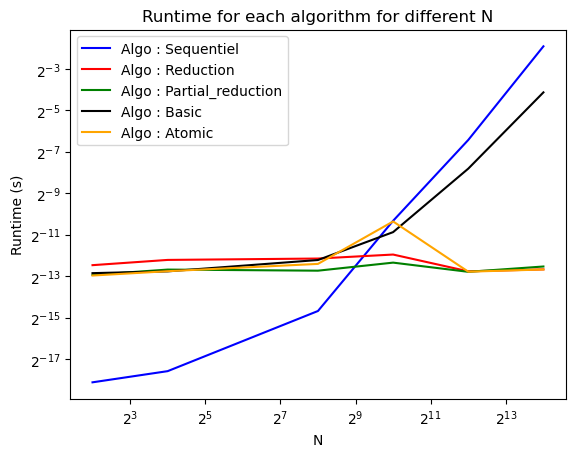

In [3]:
for algo in algo_compare:
    df_algo = df[df['version'] == algo]
    mean = df_algo.groupby(['N', "M"]).mean().reset_index()
    plt.plot(mean['N'], mean['runtime'], color=color_algo[algo], label="Algo : " + str(algo))
    
plt.legend()
plt.title("Runtime for each algorithm for different N")
plt.xlabel("N")
plt.ylabel("Runtime (s)")
plt.yscale('log', base=2)
plt.xscale('log', base=2)
plt.show()

La première qu'on peux voir sur ce graphique est le temps d'execution plus élevé pour les algorithme séquentiel et basic par rapport aux autres. Mais ce graphique est biaisé. En effet, les temps de calculs aux delà de 2^10 N ne sont pas représentatifs (les algorithmes ne le gèrent pas).

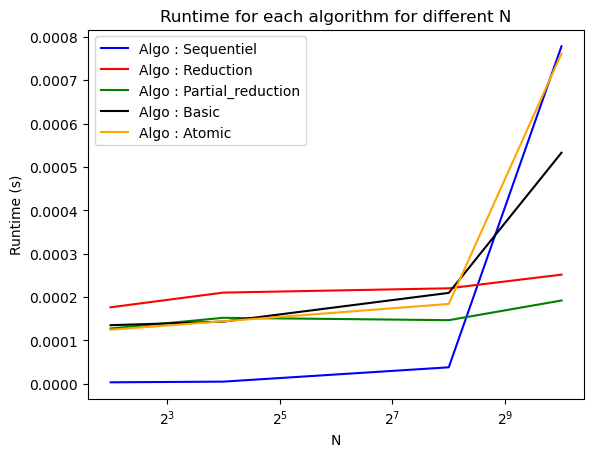

In [4]:
dfInf10 = df[df['N'] <= 1024]
for algo in algo_compare:
    df_algo = dfInf10[dfInf10['version'] == algo]
    mean = df_algo.groupby(['N', "M"]).mean().reset_index()
    plt.plot(mean['N'], mean['runtime'], color=color_algo[algo], label="Algo : " + str(algo))
    
plt.legend()
plt.title("Runtime for each algorithm for different N")
plt.xlabel("N")
plt.ylabel("Runtime (s)")
#plt.yscale('log', base=2)
plt.xscale('log', base=2)
plt.show()

Ce qu'on peux voir maintenant sur le graphique, c'est que l'algorithme basic est plus rapide que l'algorithme séquentiel et atomic pour les hautes valeurs de N. Pour les plus basses valeurs de N (< 2^7) l'algorithme sequentiel est bien plus rapides que les algorithmes cuda. Cela est du aux temps de transferts des données entre le CPU et le GPU. Enfin, l'algorithmes de reduction partiel est plus rapide que l'algorithme de reduction totale.